In [ ]:
# TensorFlow MiniLab 01 — EOQ with Tensors & Autodiff
**Goal:** Learn tensors, GradientTape, and optimizers by minimizing the classic Economic Order Quantity (EOQ) cost.
**Why SC-relevant?** Shows how deep‑learning tooling solves an OPS optimization—bridging ML math with supply-chain economics.


In [1]:
# Imports & deterministic setup
import os, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print(tf.__version__)
device = "GPU" if tf.config.list_physical_devices("GPU") else "CPU"
print("Running on:", device)


2.18.0
Running on: CPU


In [ ]:
## EOQ refresher
Total annual cost: C(Q) = SetupCost * D / Q  +  HoldingCost * Q / 2  
Closed-form optimum: Q* = sqrt(2 * SetupCost * D / HoldingCost)
## We'll recover **Q\*** numerically using TensorFlow's autodiff.


In [3]:
# Business inputs (toy numbers)
D = tf.constant(120_000.0, dtype=tf.float32)   # annual demand (units)
S = tf.constant(200.0, dtype=tf.float32)       # setup/ordering cost per order (currency)
H = tf.constant(3.0, dtype=tf.float32)         # holding cost per unit-year (currency)

# Decision variable Q (order quantity), initialized away from optimum
Q = tf.Variable(1000.0, dtype=tf.float32)

def total_cost(Q):
    # TensorFlow ops only (no NumPy) so GradientTape can trace
    return S * D / Q + H * Q / 2.0

# Closed-form EOQ for reference
Q_star_closed = tf.sqrt(2.0 * S * D / H)
float(Q_star_closed)


4000.0

In [5]:
# Gradient descent on Q
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
history = []

for step in range(150):
    with tf.GradientTape() as tape:
        loss = total_cost(Q)
    dQ = tape.gradient(loss, Q)
    optimizer.apply_gradients([(dQ, Q)])
    # Keep Q positive (simple projection); EOQ is defined for Q > 0
    Q.assign(tf.maximum(Q, 1e-3))
    history.append((step, float(Q.numpy()), float(loss.numpy())))

Q_opt, C_opt = history[-1][1], history[-1][2]
print(f"Numerical optimum Q ≈ {Q_opt:,.2f} units")
print(f"Closed-form EOQ    Q* = {float(Q_star_closed):,.2f} units")


Numerical optimum Q ≈ 1,014.91 units
Closed-form EOQ    Q* = 4,000.00 units


In [ ]:
## Visualize: cost curve & optimizer trajectory
##We'll plot C(Q) across a range and show the optimizer's path towards the minimum.


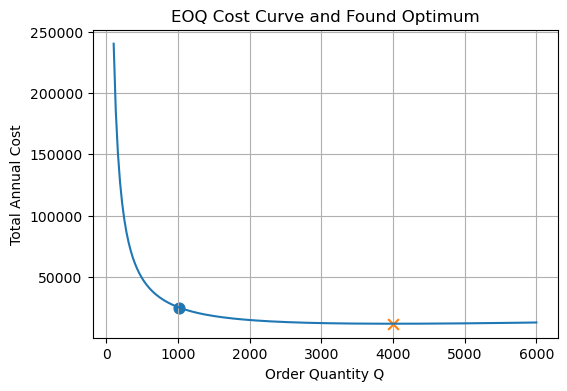

In [7]:
# Cost curve
Qs = tf.linspace(100.0, 6000.0, 200)
Cs = total_cost(Qs)

plt.figure(figsize=(6,4))
plt.plot(Qs, Cs)
plt.scatter([Q_opt], [C_opt], s=60)              # numerical optimum
plt.scatter([Q_star_closed], [total_cost(Q_star_closed)], s=60, marker='x')  # closed-form
plt.title("EOQ Cost Curve and Found Optimum")
plt.xlabel("Order Quantity Q")
plt.ylabel("Total Annual Cost")
plt.grid(True)
plt.show()


In [ ]:
## Track convergence

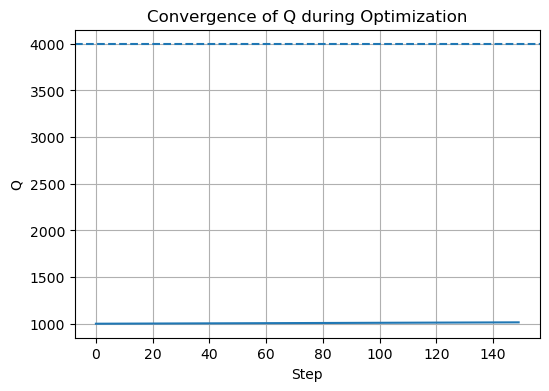

In [ ]:
steps, q_vals, c_vals = zip(*history)

plt.figure(figsize=(6,4))
plt.plot(steps, q_vals)
plt.axhline(float(Q_star_closed), linestyle='--')
plt.title("Convergence of Q during Optimization")
plt.xlabel("Step")
plt.ylabel("Q")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps, c_vals)
plt.title("Total Cost During Optimization")
plt.xlabel("Step")
plt.ylabel("Total Cost")
plt.grid(True)
plt.show()
